In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from utils import data, plot, evaluate
import models
from models import GRU, LSTM

# Set device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Load Data

In [2]:
data_dir = 'data/CMAPSS'
subset = 1
train, test, header, n_meta, n_sensors, n_settings = data.load_cmapss_subset(
    data_dir, subset)

params = {
    'drop_sensors': [1, 5, 6, 10, 16, 18, 19],
    'include_settings': None,
    'smooth': 0,
    'lag': 20,
    'clip': 150,
    'cv_folds': None,
    'return_cols': True,
    'reshape_2d': True
}
X, y, _, cols = data.build_dataset(train, **params)
X_test, y_test, _, cols = data.build_dataset(test, **params, test=True)

scaler = StandardScaler()
X, y, scaler = models.preprocess(X, y, scaler, fit_scaler=True)
X_test, y_test, scaler = models.preprocess(X_test, y_test, scaler, fit_scaler=False)

print(X.shape, y.shape)

batch_size = 2048

train_data = TensorDataset(
    torch.from_numpy(X),
    torch.from_numpy(y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

test_data = TensorDataset(
    torch.from_numpy(X_test),
    torch.from_numpy(y_test))
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size, drop_last=False)

(18631, 14, 21) (18631, 1)


GRU Model
------------------


Epochs:   0%|          | 0/3 [00:00<?, ?it/s]

Training Batches:   0%|          | 0/9 [00:00<?, ?it/s]

---
Test Set - MAPE=0.846 - MAE=69.678 - MSE=6581.876 - RMSE=81.129 - R2=-2.811


Text(0.5, 1.0, 'Test Set Predictions')

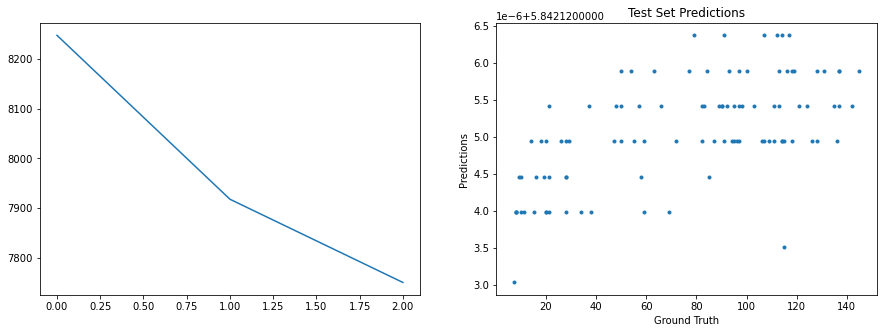

In [3]:
model_params = {
    'batch_size': batch_size,
    'learning_rate': 0.001,
    'epochs': 300,
    'model_type': 'GRU',
    'criterion': nn.L1Loss(),
}

print(f'{model_params["model_type"]} Model\n----------')
model, history = models.train(device, train_loader, **model_params)
print('---')
y_pred = models.predict(device, model, X_test, y_test)
metrics = evaluate.metrics(y_test, y_pred)
print('Test Set - MAPE={:.3f} - MAE={:.3f} - MSE={:.3f} - RMSE={:.3f} - R2={:.3f}'.format(*metrics))

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(history['losses'])
axes[1].plot(y_test, y_pred, '.')
axes[1].set_ylabel('Predictions')
axes[1].set_xlabel('Ground Truth')
axes[1].set_title('Test Set Predictions')
axes[1].set_ylim([0, 150])
axes[1].set_xlim([0, 150])
fig.show()